# Perform a thorough analysis and prediction of Microsoft stock

### Aim to find out:
1. The most impacting factors in each of the three datasets collected
2. Compare the performance of:
    * basic XGBoost models
    * advanced LSTMs
    * classical methods with facebook PROPHET2
3. The feasibility of prediction based on news sentiments alone
4. Find the most impactful news outlet - closest one to real prediction of the stock

### The final goal would be to create an automatic version that would go over all stocks and suggest the most profitable one

# Step1: Create the dataset to train on

## Pull all the data from alpha vantage

In [121]:
import requests
from pprint import pprint
import mplfinance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import json
import time
from tqdm import tqdm
import calendar
import os
import logging
colors = sns.color_palette()
sns.set()
pd.set_option('display.max_colwidth',1000)

In [ ]:
# set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# create a file handler
handler = logging.FileHandler('msft_analysis.log')
handler.setLevel(logging.INFO)
# create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(handler)

In [2]:
import string
import random

def get_data(parameters):
    endpoint = "https://www.alphavantage.co/query"
    for _ in range(100):
        parameters['apikey'] = ''.join(random.choices(string.ascii_uppercase + string.digits, k=15))
        # Send a GET request to the API endpoint
        response = requests.get(endpoint, params=parameters)
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            if 'Note' not in data: 
                break
            logger.warning(f'API key {parameters["apikey"]} has been used too many times. response note: {data["Note"]}')
            data = None
            time.sleep(1)
        else: 
            logger.error(f'API key {parameters["apikey"]} has returned an error. response note: {response.json()}')
    return data

### Get all prices up to 2 years ago

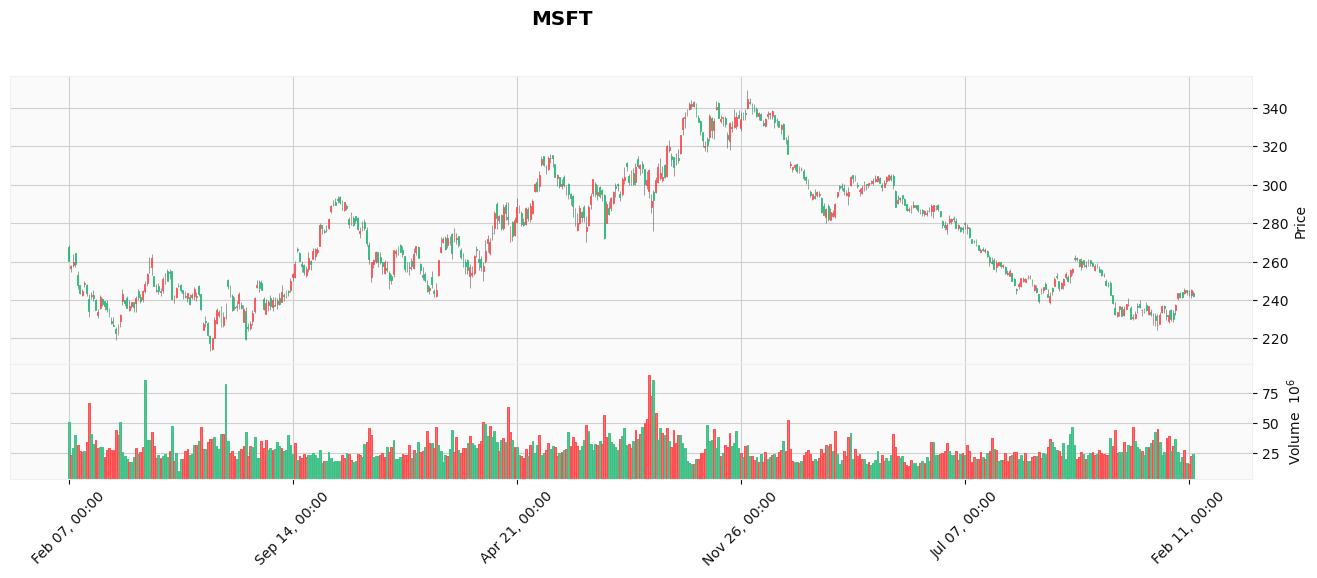

In [131]:
parameters = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": 'MSFT',
        "outputsize": 'full'
    }
prices = get_data(parameters)
# convert to pandas dataframe
price_df = pd.DataFrame.from_dict(prices['Time Series (Daily)'], orient='index')
price_df.index = pd.to_datetime(price_df.index)
# take only the data up to 2 years ago and convert to numeric
price_df = price_df[price_df.index > datetime.now() - timedelta(days=365*2)].apply(pd.to_numeric)
# rename columns
price_df.columns = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']
# save to csv
price_df.to_csv('msft_prices.csv', index=True)
# create a candlestick plot
mplfinance.plot(price_df[['open', 'high', 'low', 'close', 'volume']], type='candle', style='yahoo', volume=True, title='MSFT', figratio=(15, 5))


### get all the company's financial sheets

Pull all financial sheets from alpha vantage

In [35]:
functions = ['OVERVIEW', 'INCOME_STATEMENT', 'BALANCE_SHEET', 'CASH_FLOW', 'EARNINGS']
overviews = [get_data({"function": function, "symbol": 'MSFT', "horizon": "12month"}) for function in functions]
# save to json in a different directory
os.makedirs('msft_data', exist_ok=True)
for overview, function in zip(overviews, functions):
    with open(f'msft_data/msft_{function.lower()}.json', 'w') as outfile:
        json.dump(overview, outfile, indent=4)

Create the overview dataframe

In [70]:
def convert_overview_to_dataframe(overview):
    keys = []
    cols = []
    for key, val in overview.items():
        try:
            cols.append(float(val))
            if key not in keys: keys.append(key)
        # create an exception when the value is not a number
        except ValueError:
            try:
                cols.append(datetime.strptime(val, '%Y-%m-%d'))
                if key not in keys: keys.append(key)
            except ValueError:
                pass
    # return keys, cols
    return pd.DataFrame([cols], columns=keys)

overview_df = convert_overview_to_dataframe(overviews[0])
overview_df.to_csv('msft_overview.csv', index=False)
overview_df

,CIK,LatestQuarter,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendPerShare,DividendYield,EPS,...,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,DividendDate,ExDividendDate
0,789019.0,2022-12-31,1.991663e+12,9.794500e+10,29.73,2.275,24.59,2.6,0.0106,9.0,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15


Create the earnings dataframe

In [57]:
earnings_ds = pd.DataFrame.from_dict(overviews[4]['quarterlyEarnings'])
earnings_ds['fiscalDateEnding'] = pd.to_datetime(earnings_ds['fiscalDateEnding'])
earnings_ds['reportedDate'] = pd.to_datetime(earnings_ds['reportedDate'])
# take only up to 2 years ago
earnings_ds = earnings_ds[earnings_ds['fiscalDateEnding'] > datetime.now() - timedelta(days=365*2)]
# convert all columns to numeric except the first two
earnings_ds.iloc[:, 2:] = earnings_ds.iloc[:, 2:].apply(pd.to_numeric)
# save to csv
earnings_ds.to_csv('msft_earnings.csv', index=False)
earnings_ds

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage
0,2022-12-31,2023-01-24,2.32,2.30,0.02,0.8696
1,2022-09-30,2022-10-25,2.35,2.30,0.05,2.1739
2,2022-06-30,2022-07-26,2.23,2.29,-0.06,-2.6201
3,2022-03-31,2022-04-26,2.22,2.19,0.03,1.3699
4,2021-12-31,2022-01-25,2.48,2.31,0.17,7.3593
5,2021-09-30,2021-10-26,2.27,2.08,0.19,9.1346
6,2021-06-30,2021-07-27,2.17,1.92,0.25,13.0208
7,2021-03-31,2021-04-27,2.03,1.78,0.25,14.0449


### Get all the news sentiments

Reload the previous dataset

In [326]:
try: 
    sent_df = pd.read_csv('msft_sentiments.csv').drop(columns=['Unnamed: 0'], errors='ignore')
except FileNotFoundError: 
    sent_df = pd.DataFrame()

Create a new dataframe from the saved jsons

In [329]:
rows = []
# get a list of all files in the sentiments folder
for news_file in tqdm(os.listdir('sentiments')):
    with open(os.path.join('sentiments', news_file)) as f:
        news = json.load(f)
    if 'feed' not in news: continue
    for article in news['feed']:
        # parse date time from YYYYMMDDTHHMM format to datetime object
        time_pub = datetime.strptime(article['time_published'], '%Y%m%dT%H%M%S')
        # find item in list of dictionaries that contains a value matching 'MSFT'
        msft_sent = [item for item in article['ticker_sentiment'] if item['ticker'] == 'MSFT'][0]
        rows.append([msft_sent['ticker_sentiment_score'], msft_sent['relevance_score'], time_pub, article['url']])
        
# new_df = pd.DataFrame(ordered_sentiments).sort_values(by='time', ascending=False)
new_df = pd.DataFrame(rows, columns=['sentiment', 'relevance', 'time', 'url'])
# parse out anything between https:// and / in the url or http:// and / in the url
new_df['site'] = new_df['url'].apply(lambda x: x.split('https://')[1].split('/')[0] if 'https' in x else x.split('http://')[1].split('/')[0])
new_df.drop(columns=['url'], inplace=True)
# create a dataframe from the list of dictionaries and add it to the existing dataframe
new_sent_df = pd.concat([new_df, sent_df], axis=0, ignore_index=True)

100%|██████████| 142/142 [00:00<00:00, 552.53it/s]


Combine the two dataframes and save to csv

In [330]:
new_sent_df['sentiment'] = new_sent_df['sentiment'].astype(float)
new_sent_df['time'] = pd.to_datetime(new_sent_df['time'])
new_sent_df = new_sent_df.drop_duplicates(ignore_index=True).sort_values(by='time', ascending=False)
new_sent_df.reset_index(inplace=True, drop=True)
# save the dataframe to a csv file
new_sent_df.to_csv(f'msft_sentiments.csv', index=False)
new_sent_df

,sentiment,relevance,time,site
0,0.093853,0.047371,2023-02-08 13:00:14,www.scmp.com
1,-0.299148,0.065327,2023-02-08 12:51:00,www.cnn.com
2,-0.106790,0.382925,2023-02-08 12:49:00,www.wsj.com
3,0.224523,0.295867,2023-02-08 12:46:00,www.reuters.com
4,0.000000,0.511256,2023-02-08 12:39:00,www.business-standard.com
...,...,...,...,...
17224,-0.215272,0.09923,2022-03-02 08:00:00,www.axios.com
17225,-0.688359,0.127795,2022-03-02 08:00:00,www.fastcompany.com
17226,-0.092053,0.079078,2022-03-02 03:06:42,www.scmp.com
17227,-0.092053,0.079078,2022-03-02 03:06:42,www.scmp.com


## Combine all dataframes into a single dataset

Load the sentiment dataframe and average the daily sentiment

Text(0.5, 0, '')

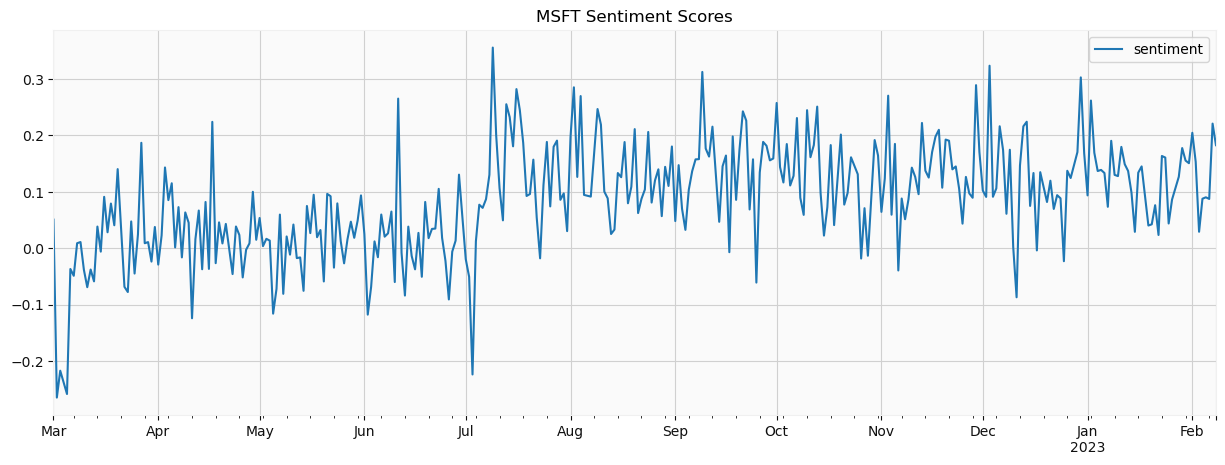

In [469]:
# read the csv file and convert the time column to datetime. ignore the index column
df = pd.read_csv('msft_sentiments.csv')
df['time'] = pd.to_datetime(df['time'])
# group the dataframe by day, average sentiment scores weighted by relevance
df = pd.DataFrame(df.groupby(pd.Grouper(key='time', freq='D')).apply(lambda x: np.average(x['sentiment'], weights=x['relevance'])), columns=['sentiment']).sort_index(ascending=False)
# # plot the sentiment scores
df.plot(figsize=(15, 5), title='MSFT Sentiment Scores', label='sentiment')
# # add a trendline to the plot
# mv_avg = 7
# df['trend'] = df['sentiment'].rolling(mv_avg).mean()
# df['trend'].plot(figsize=(15, 5), title='MSFT Sentiment Scores', label=f'{mv_avg} day moving average')
plt.xlabel('')
# plt.legend()
# df = df.drop(columns=['trend']).sort_index(ascending=False)

Load the daily price data and append it to the news dataset

In [470]:
prices_df = pd.read_csv('msft_prices.csv', index_col=0)
# sort the prices by date
prices_df.index = pd.to_datetime(prices_df.index)
prices_df.sort_index(ascending=False, inplace=True)
df = df.join(prices_df, how='left').drop(columns=['split_coefficient', 'dividend_amount'], errors='ignore')
# normalize each of the columns between -1 and 1
# df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()) * 2 - 1)
# for every nan value, replace it with the value of the previous day
df.fillna(method='ffill', inplace=True)
# normalize according to the mean and standard deviation
# new_df.iloc[:, 1:] = new_df.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std())
# new_df = new_df.apply(lambda x: (x - x.mean()) / x.std())
df

,sentiment,open,high,low,close,adjusted_close,volume
time,,,,,,,
2023-02-08,0.182561,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-07,0.220816,260.53,268.775,260.080,267.56,267.560000,50841365.0
2023-02-06,0.087376,257.44,258.300,254.780,256.77,256.770000,22517997.0
2023-02-05,0.090266,257.44,258.300,254.780,256.77,256.770000,22517997.0
2023-02-04,0.087724,257.44,258.300,254.780,256.77,256.770000,22517997.0
...,...,...,...,...,...,...,...
2022-03-05,-0.258166,288.53,289.690,278.530,278.91,276.861355,43157178.0
2022-03-04,-0.236631,294.29,295.660,287.165,289.86,287.730925,32369655.0
2022-03-03,-0.216885,302.89,303.130,294.050,295.92,293.746413,27314469.0


Plot everything while scaling the sentiments by a factor of 10

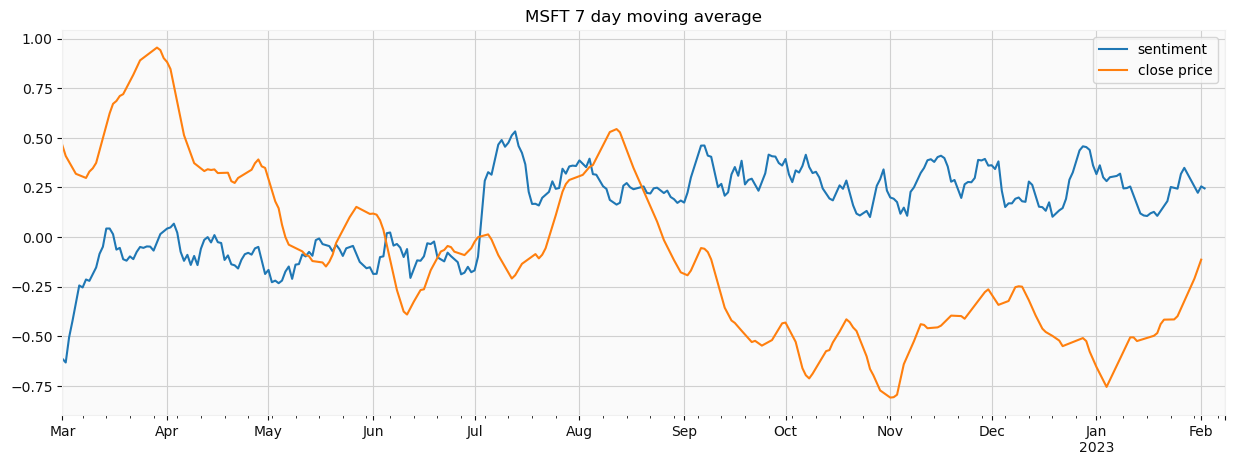

In [471]:
# plot the sentiment scores
mv_avg = 7
temp_df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()) * 2 - 1)
# multiply the sentiment scores by 2 to make the trendline more visible
temp_df['sentiment'].rolling(mv_avg).mean().plot(figsize=(15, 5), title=f'MSFT {mv_avg} day moving average', label=f'sentiment')
# new_df['close'].plot(figsize=(15, 5), title='MSFT Sentiment Scores', label='close')
temp_df['close'].rolling(mv_avg).mean().plot(figsize=(15, 5), title=f'MSFT {mv_avg} day moving average', label=f'close price')
# add vertical lines to indicate 
# plt.axvline(x='2022-07-13', color='red', linestyle='--')
# plt.axvline(x='2022-08-12', color='black', linestyle='--')
plt.xlabel('')
plt.legend()

Load the overview dataframe and append it as well

In [472]:
overview_df = pd.read_csv('msft_overview.csv')
# convert any value that could be converted to a float to a float
overview_df = overview_df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
# convert any value that could be converted to a datetime to a datetime except numeric values
overview_df = overview_df.apply(lambda x: pd.to_datetime(x, errors='ignore') if x.dtype != 'float64' else x)
new_df = df.copy()
for col in overview_df.columns:
    new_df[col] = overview_df[col][0]
new_df.to_csv('msft_dataset.csv')
new_df

,sentiment,open,high,low,close,adjusted_close,volume,CIK,LatestQuarter,MarketCapitalization,...,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,DividendDate,ExDividendDate
time,,,,,,,,,,,,,,,,,,,,,
2023-02-08,0.182561,NaN,NaN,NaN,NaN,NaN,NaN,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2023-02-07,0.220816,260.53,268.775,260.080,267.56,267.560000,50841365.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2023-02-06,0.087376,257.44,258.300,254.780,256.77,256.770000,22517997.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2023-02-05,0.090266,257.44,258.300,254.780,256.77,256.770000,22517997.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2023-02-04,0.087724,257.44,258.300,254.780,256.77,256.770000,22517997.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-05,-0.258166,288.53,289.690,278.530,278.91,276.861355,43157178.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2022-03-04,-0.236631,294.29,295.660,287.165,289.86,287.730925,32369655.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2022-03-03,-0.216885,302.89,303.130,294.050,295.92,293.746413,27314469.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15


<span style="color:red">TODO Also add the earnings dataset</span>

# Step 2: Run in XGBoost and define the most impacting features

### <span style="color:red">TODO make it predict the weekly price instead. And feed it volume, high, and low of the previous days (move every item to be a day backward when feeding)</span>

In [473]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb

## Split to train and test data

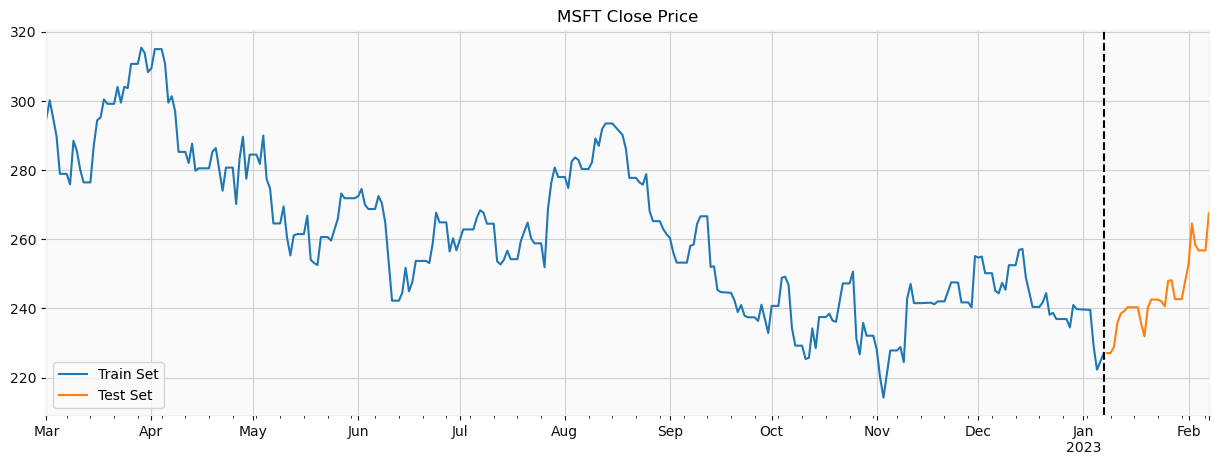

In [491]:
df = pd.read_csv('msft_dataset.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.sort_index(ascending=False, inplace=True)
# drop any column that contains a date time value
df = df.drop(columns=[col for col in df.columns if df[col].dtype != 'float64']).dropna()
# normalize values
# df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()) * 2 - 1)
# also drop any values that could contribute to overfitting
df = df.drop(columns=['adjusted_close', 'high', 'low'])
# get all times before the last month
train_df, test_df = df[df.index < df.index.max() - pd.DateOffset(days=30)], df[df.index >= df.index.max() - pd.DateOffset(days=30)]
# plot both the training and testing data
train_df['close'].plot(figsize=(15, 5), title='MSFT Close Price', label='Train Set')
test_df['close'].plot(figsize=(15, 5), title='MSFT Close Price', label='Test Set')
# add vertical lines to indicate the separation between the training and testing data
plt.axvline(x=train_df.index[0], color='black', linestyle='--')
plt.xlabel('')
plt.legend()

## create a xgboost regression

In [492]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100, eval_metric='rmse', learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
X_train = train_df.drop(columns=['close'])
y_train = train_df['close']
X_test = test_df.drop(columns=['close'])
y_test = test_df['close']
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
print('done')

[0]	validation_0-rmse:235.92239	validation_1-rmse:219.33254
[1]	validation_0-rmse:212.58186	validation_1-rmse:197.33714
[2]	validation_0-rmse:191.61157	validation_1-rmse:177.50821
[3]	validation_0-rmse:172.72731	validation_1-rmse:159.86304
[4]	validation_0-rmse:155.67940	validation_1-rmse:143.77541
[5]	validation_0-rmse:140.33066	validation_1-rmse:129.26794
[6]	validation_0-rmse:126.56581	validation_1-rmse:115.44305
[7]	validation_0-rmse:114.12487	validation_1-rmse:102.93592
[8]	validation_0-rmse:102.94213	validation_1-rmse:92.63089
[9]	validation_0-rmse:92.84446	validation_1-rmse:83.47176
[10]	validation_0-rmse:83.67911	validation_1-rmse:75.10857
[11]	validation_0-rmse:75.48493	validation_1-rmse:67.72275
[12]	validation_0-rmse:68.08174	validation_1-rmse:61.11047
[13]	validation_0-rmse:61.42612	validation_1-rmse:54.96513
[14]	validation_0-rmse:55.51047	validation_1-rmse:48.98317
[15]	validation_0-rmse:50.11510	validation_1-rmse:44.21367
[16]	validation_0-rmse:45.23529	validation_1-rmse

<AxesSubplot:title={'center':'Feature Importance'}>

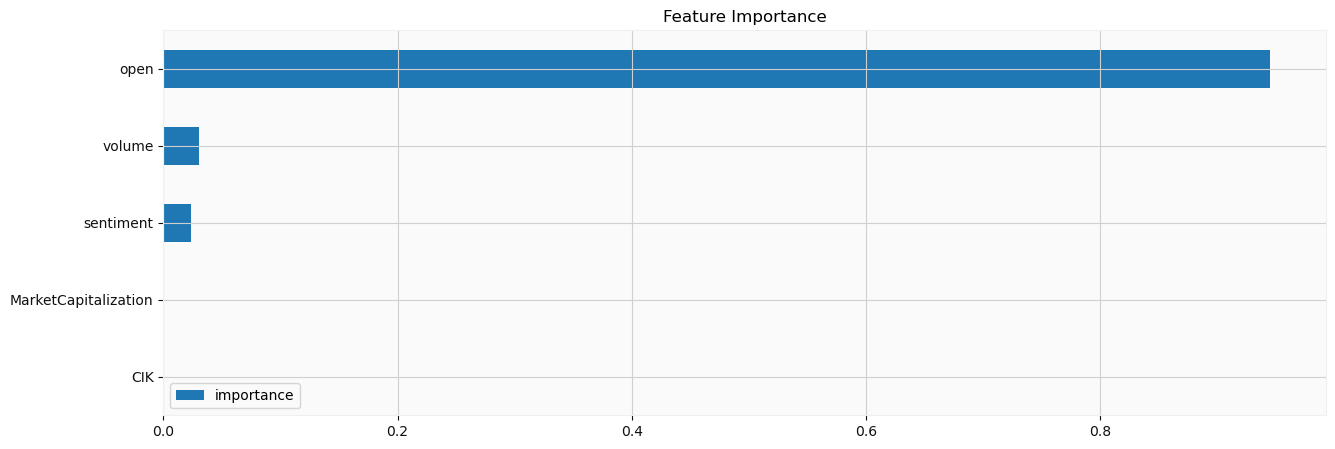

In [493]:
fi = pd.DataFrame(reg.feature_importances_[:5], index=reg.feature_names_in_[:5], columns=['importance']).sort_values(by='importance')
fi.plot(kind='barh', figsize=(15, 5), title='Feature Importance')

## Forecast on Test

In [494]:
X_test['prediction'] = reg.predict(X_test)
df = df.merge(X_test[['prediction']], how='left', left_index=True, right_index=True)
df

,sentiment,open,close,volume,CIK,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,...,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,prediction
time,,,,,,,,,,,,,,,,,,,,,
2023-02-07,0.220816,260.530,267.56,50841365.0,789019.0,1.991663e+12,9.794500e+10,29.73,2.275,24.59,...,11.05,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,259.602417
2023-02-06,0.087376,257.440,256.77,22517997.0,789019.0,1.991663e+12,9.794500e+10,29.73,2.275,24.59,...,11.05,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,259.353577
2023-02-05,0.090266,257.440,256.77,22517997.0,789019.0,1.991663e+12,9.794500e+10,29.73,2.275,24.59,...,11.05,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,259.670685
2023-02-04,0.087724,257.440,256.77,22517997.0,789019.0,1.991663e+12,9.794500e+10,29.73,2.275,24.59,...,11.05,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,259.353577
2023-02-03,0.029203,259.542,258.35,29077256.0,789019.0,1.991663e+12,9.794500e+10,29.73,2.275,24.59,...,11.05,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,257.432526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-05,-0.258166,288.530,278.91,43157178.0,789019.0,1.991663e+12,9.794500e+10,29.73,2.275,24.59,...,11.05,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,NaN
2022-03-04,-0.236631,294.290,289.86,32369655.0,789019.0,1.991663e+12,9.794500e+10,29.73,2.275,24.59,...,11.05,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,NaN
2022-03-03,-0.216885,302.890,295.92,27314469.0,789019.0,1.991663e+12,9.794500e+10,29.73,2.275,24.59,...,11.05,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,NaN


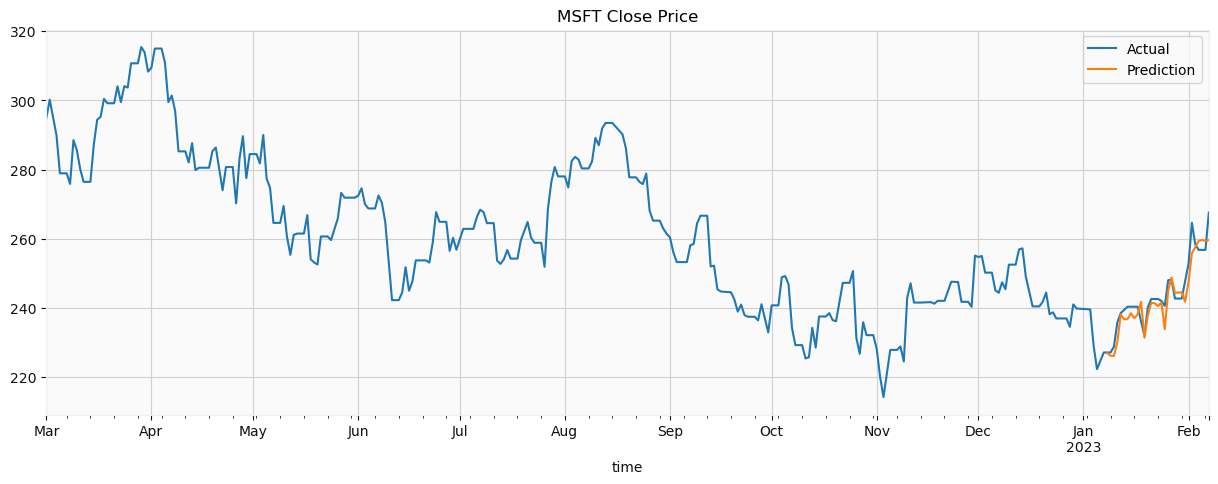

In [495]:
df['close'].plot(figsize=(15, 5), title='MSFT Close Price', label='Actual')
df['prediction'].plot(figsize=(15, 5), title='MSFT Close Price', label='Prediction')
plt.legend()

Print out the root mean squared error

In [503]:
score = np.sqrt(mean_squared_error(y_test, X_test['prediction']))
print(f'RMSE: {score:.4f}')

RMSE: 3.6720


Print out the predicted days

In [504]:
X_test['error'] = np.abs(X_test['prediction'] - y_test)
X_test['date'] = X_test.index
X_test.groupby(['date']).mean().sort_values(ascending=False, by='error')['error'].head()

date
2023-02-02    8.785318
2023-02-07    7.957583
2023-01-25    6.740829
2023-01-31    5.997912
2023-01-18    5.933164
Name: error, dtype: float64

# Next steps
- Create more robust cross validation
- Move to predicting weekly data
- find out how to milk your other features better